In [1]:
import torch
from sam2.build_sam import build_sam2_video_predictor
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os
from os.path import join
from PIL import Image

In [2]:
video_root = "/home/george/data/gijs/videos"
image_root = "/home/george/data/gijs/images"
video_filenames = os.listdir(video_root)
video_paths = [join(video_root, f) for f in video_filenames]
def video_generator(path):
    """Iterate over a cv2.VideoCapture and gracefully stop when finised.
    """
    cap = cv2.VideoCapture(path)
    ret, frame = cap.read()
    yield frame
    while(1):
        ret, frame = cap.read()
        if cv2.waitKey(1) & 0xFF == ord('q') or ret==False :
            cap.release()
            cv2.destroyAllWindows()
            break
        yield frame 

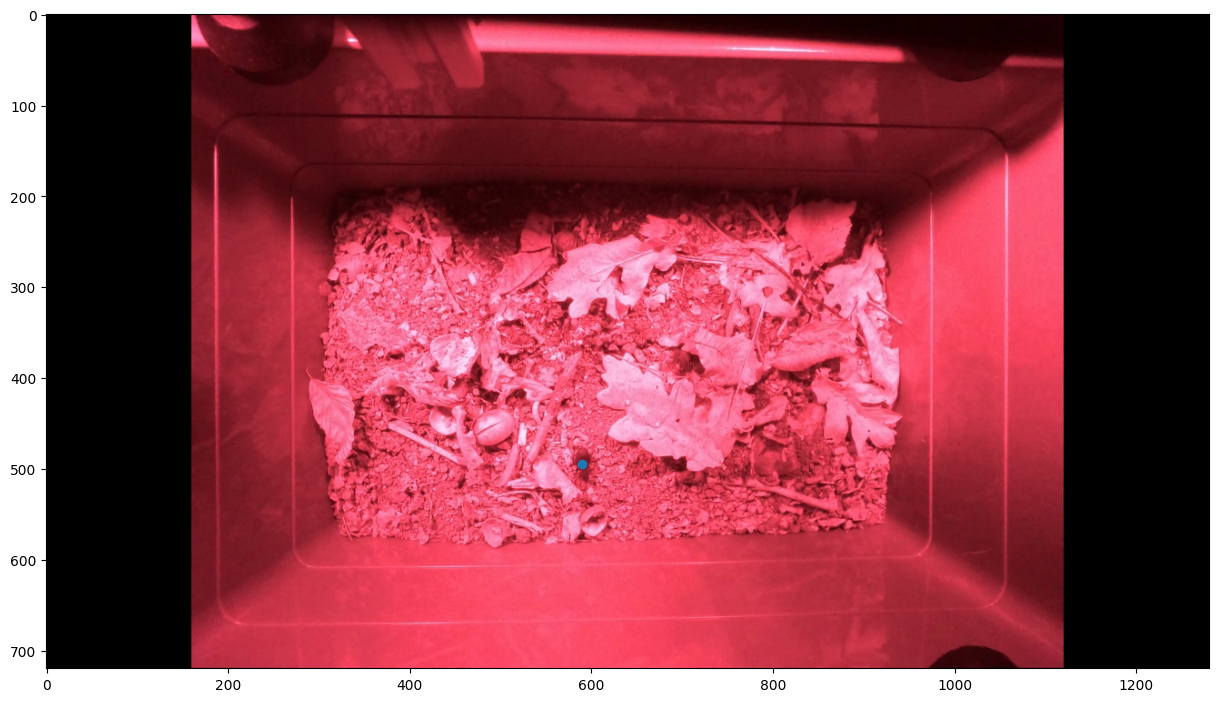

In [3]:
frame = next(video_generator(video_paths[0]))
plt.figure(figsize=(15,15))
plt.imshow(frame)
plt.plot([590], [495], "-o")

In [ ]:
checkpoint = "/home/george/data/models/sam/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = build_sam2_video_predictor(model_cfg, checkpoint)

Convert video to image sequence with ffmpeg

In [ ]:
# !ffmpeg -i "Pterostichus(kootje)_20251101.mp4" -q:v 2 -start_number 0 image_seq_video1/'%05d.jpg'

In [23]:
video_dir = "/home/george/codes/notebooks/data/gijs/videos/image_seq_video1"

In [ ]:
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [28]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [ ]:
inference_state = predictor.init_state(video_path=video_dir)

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[590, 495]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }



/tmp/ipykernel_3822367/917967784.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 4))


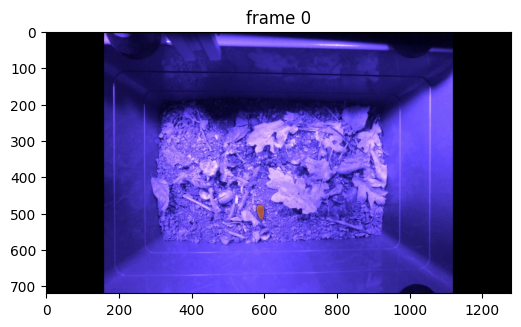

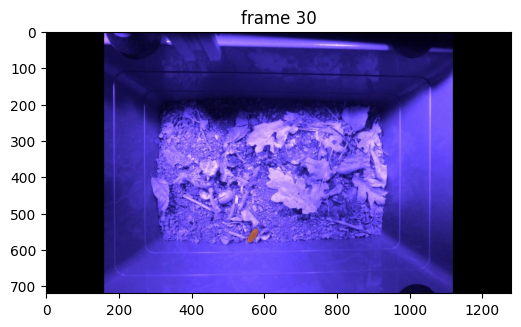

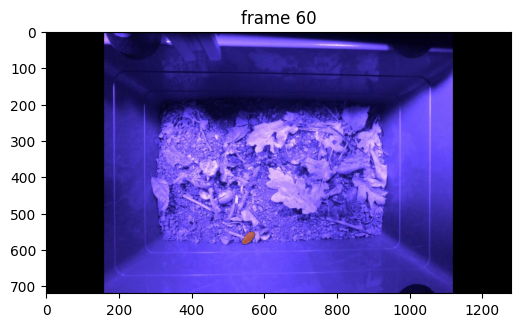

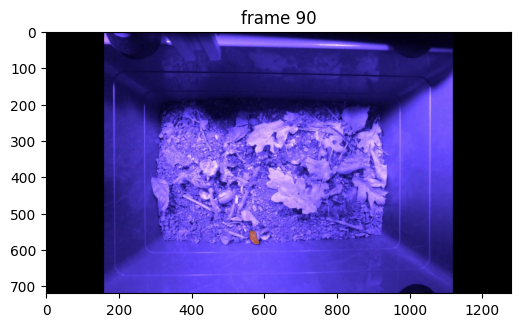

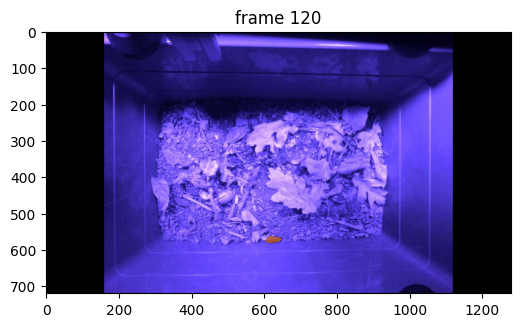

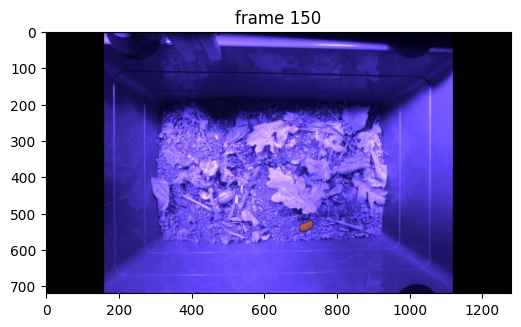

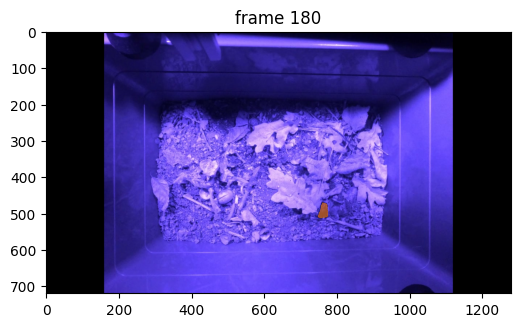

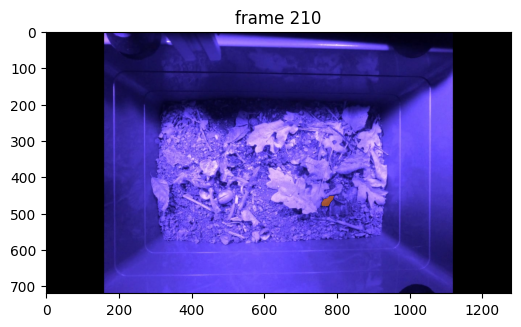

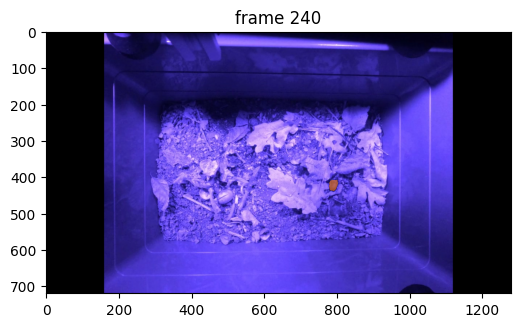

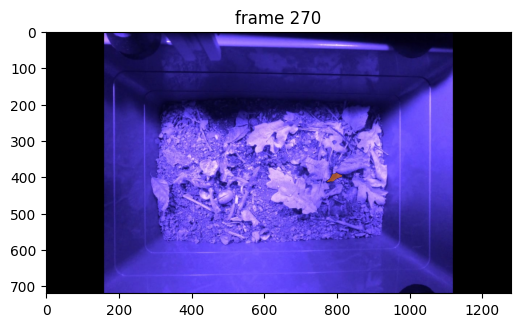

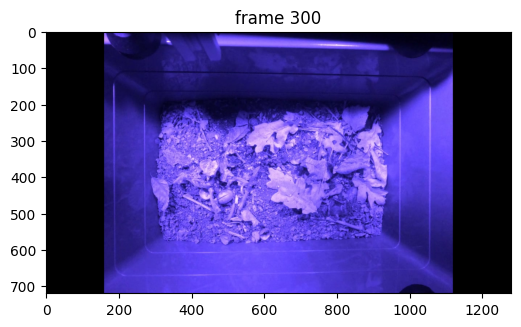

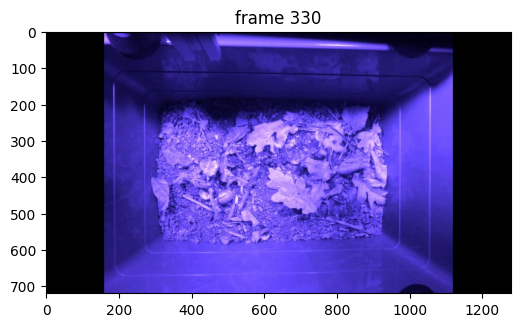

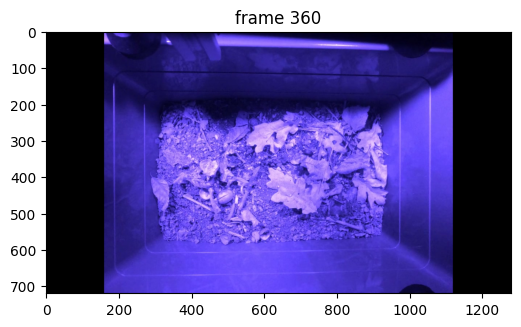

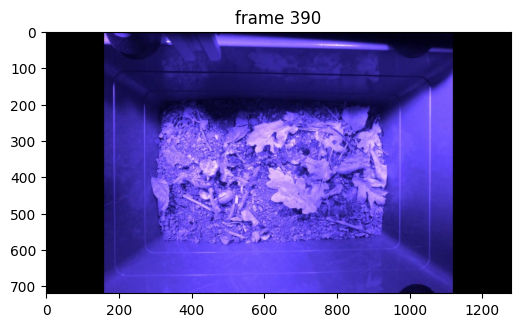

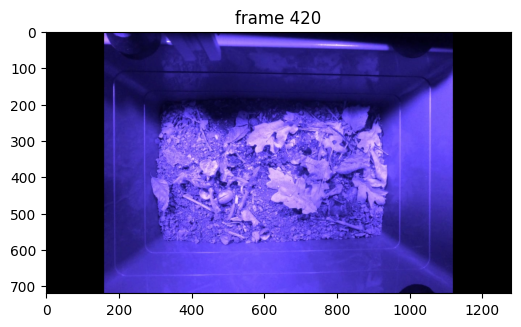

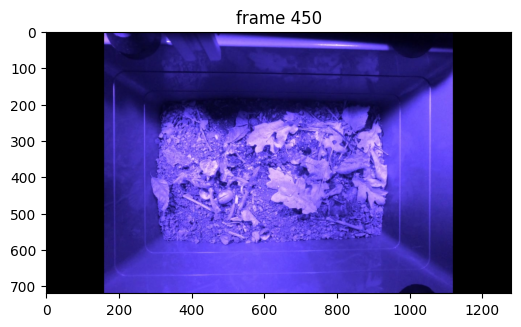

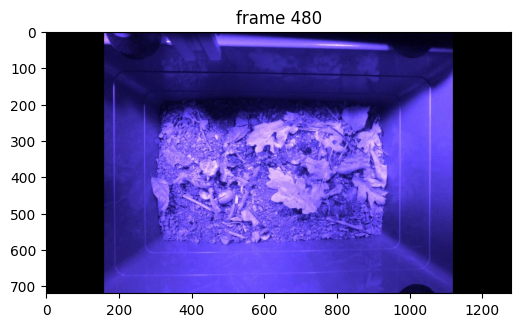

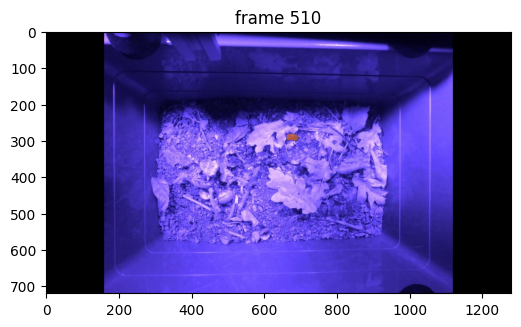

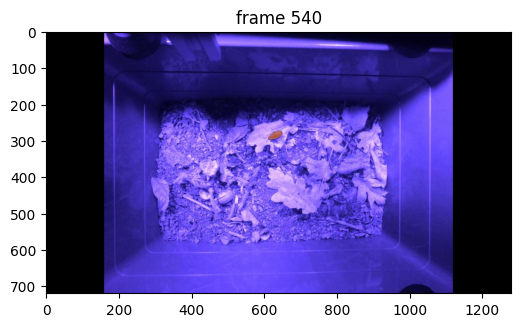

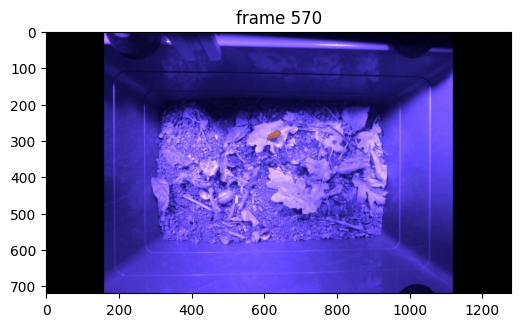

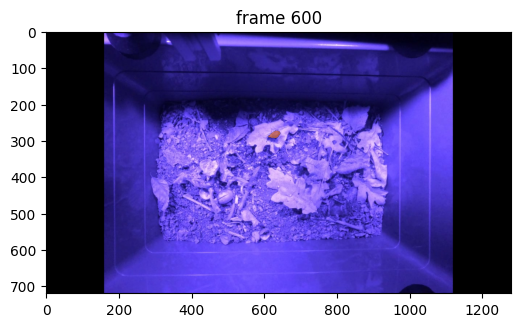

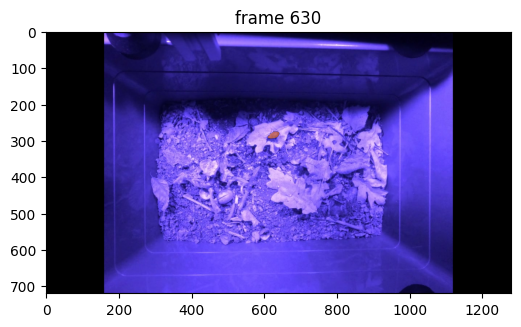

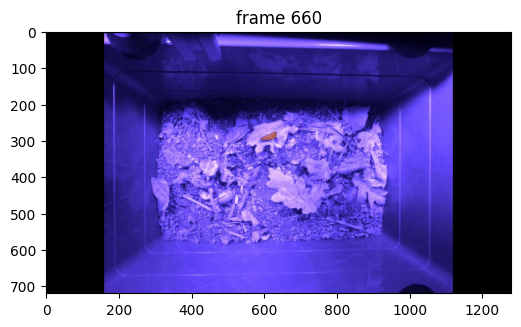

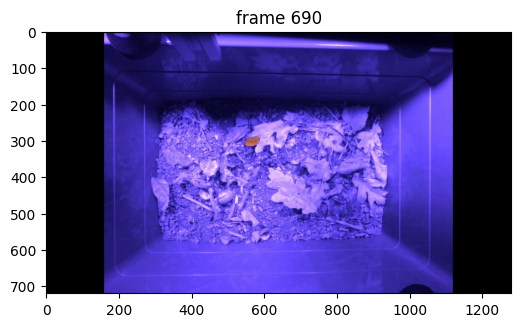

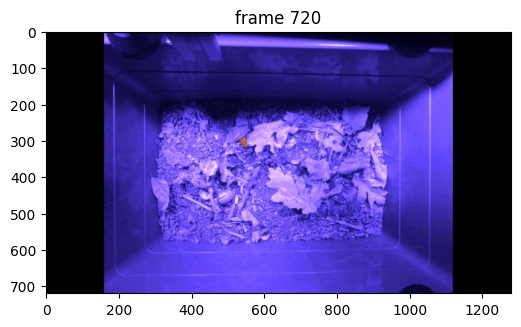

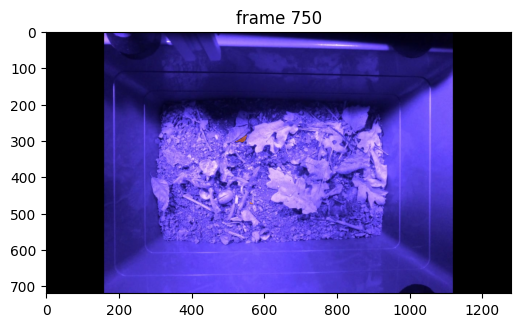

In [31]:
# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)